In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, SpatialDropout1D

from sklearn.model_selection import train_test_split
from sklearn import metrics

Ancak, Metin gösterimi adımına geçmeden önce, önce ön işleme tabi tutulması gereken temizlenmiş bir veri kümesi elde etmeliyiz. 

## Veri kümesini yükleme ve temizleme

Veri kümesi olarak, [Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) veri kümesini kullanacağız.

In [2]:
DATA_DIR = "https://media.githubusercontent.com/media/yapay-ogrenme/casgem-eu-project-training-on-data-mining/main/PART2/Day14-NLP/notebooks/datasets/"

DATASET_PATH = DATA_DIR + "twitter_airline_sentiment_tweets.csv"

In [3]:
df = pd.read_csv(DATASET_PATH)

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

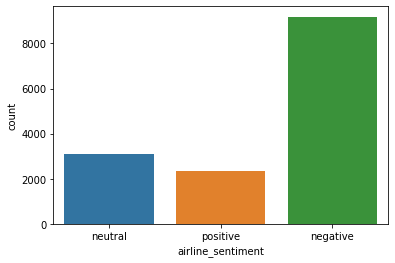

In [6]:
sns.countplot(x = "airline_sentiment", data = df)

## Temel Ön İşlemler

1. StopWord'lerin temizlenmesi
2. Küçük harfe çevirme
3. Stemming (Kök alma)
4. Tokenization


In [7]:
data = df[["airline_sentiment", "text"]]
data

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [8]:
def sentiment(x):
    if x == 'positive':
        return 1
    elif x == 'negative':
        return -1
    else:
        return 0

In [9]:
data["airline_sentiment_label"] = data["airline_sentiment"].apply(sentiment)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,airline_sentiment,text,airline_sentiment_label
0,neutral,@VirginAmerica What @dhepburn said.,0
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,0
3,negative,@VirginAmerica it's really aggressive to blast...,-1
4,negative,@VirginAmerica and it's a really big bad thing...,-1
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,1
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,-1
14637,neutral,@AmericanAir Please bring American Airlines to...,0
14638,negative,"@AmericanAir you have my money, you change my ...",-1


In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stopwords = stopwords.words('english')

def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens if token not in stopwords]
  return ' '.join(tokens[2:])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
print(f"Orignal Text : {data.text[11]}")
print()
print(f"Preprocessed Text : {clean_the_tweet(data.text[11])}")

Orignal Text : @VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D

Preprocessed Text : lt pretty graphics much better minimal iconography d


In [12]:
data["clean_text"] = data.text.map(clean_the_tweet)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,airline_sentiment,text,airline_sentiment_label,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,0,dhepburn said
1,positive,@VirginAmerica plus you've added commercials t...,1,added commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,0,today must mean i need take another trip
3,negative,@VirginAmerica it's really aggressive to blast...,-1,aggressive blast obnoxious entertainment guest...
4,negative,@VirginAmerica and it's a really big bad thing...,-1,big bad thing


In [13]:
data.iloc[10].text

'@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24'

In [14]:
data.iloc[10].clean_text

'suicide second leading cause death among teens'

In [15]:
data

,airline_sentiment,text,airline_sentiment_label,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,0,dhepburn said
1,positive,@VirginAmerica plus you've added commercials t...,1,added commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,0,today must mean i need take another trip
3,negative,@VirginAmerica it's really aggressive to blast...,-1,aggressive blast obnoxious entertainment guest...
4,negative,@VirginAmerica and it's a really big bad thing...,-1,big bad thing
...,...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,1,got different flight chicago
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,-1,minutes late flight no warnings communication ...
14637,neutral,@AmericanAir Please bring American Airlines to...,0,bring american airlines blackberry
14638,negative,"@AmericanAir you have my money, you change my ...",-1,change flight answer phones any suggestions i ...


In [16]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['clean_text'].values)

X = token.texts_to_sequences(data['clean_text'].values)
X = pad_sequences(X)

In [17]:
X.shape


(14640, 22)

In [24]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 22, 128)           256000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 22, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________


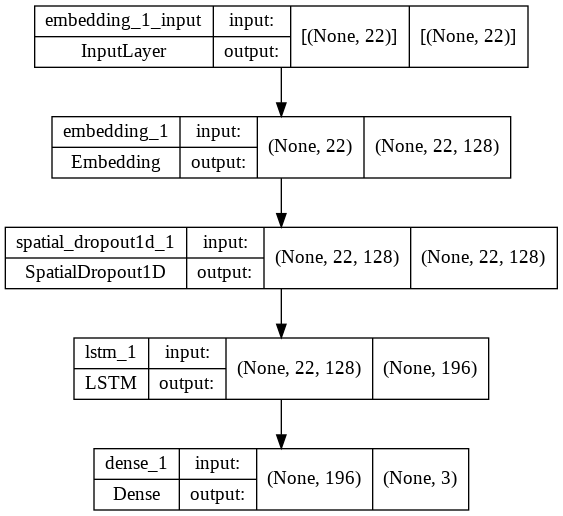

In [25]:
import tensorflow as tf

tf.keras.utils.plot_model(model, show_shapes=True)

In [26]:
Y = pd.get_dummies(data['airline_sentiment_label']).values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=42)

In [28]:
batch_size = 32
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)


Epoch 1/10
344/344 - 66s - loss: 0.7436 - accuracy: 0.6852 - val_loss: 0.6207 - val_accuracy: 0.7410 - 66s/epoch - 191ms/step
Epoch 2/10
344/344 - 63s - loss: 0.5598 - accuracy: 0.7672 - val_loss: 0.5982 - val_accuracy: 0.7607 - 63s/epoch - 184ms/step
Epoch 3/10
344/344 - 61s - loss: 0.4970 - accuracy: 0.7903 - val_loss: 0.6030 - val_accuracy: 0.7563 - 61s/epoch - 176ms/step
Epoch 4/10
344/344 - 60s - loss: 0.4562 - accuracy: 0.8092 - val_loss: 0.6407 - val_accuracy: 0.7530 - 60s/epoch - 175ms/step
Epoch 5/10
344/344 - 58s - loss: 0.4199 - accuracy: 0.8252 - val_loss: 0.6524 - val_accuracy: 0.7443 - 58s/epoch - 169ms/step
Epoch 6/10
344/344 - 59s - loss: 0.3863 - accuracy: 0.8362 - val_loss: 0.6973 - val_accuracy: 0.7500 - 59s/epoch - 172ms/step
Epoch 7/10
344/344 - 58s - loss: 0.3539 - accuracy: 0.8526 - val_loss: 0.8173 - val_accuracy: 0.7262 - 58s/epoch - 168ms/step
Epoch 8/10
344/344 - 63s - loss: 0.3327 - accuracy: 0.8619 - val_loss: 0.7872 - val_accuracy: 0.7210 - 63s/epoch - 182

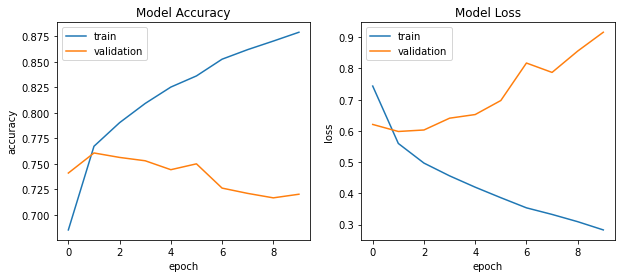

In [29]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

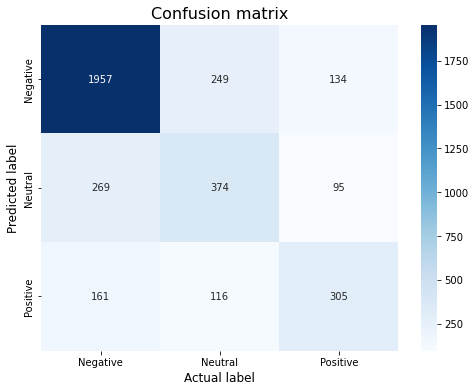

In [30]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [31]:
# score = model.predict(X_test)
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print('score', score)
print('accuracy', acc)

115/115 - 1s - loss: 0.9158 - accuracy: 0.7202 - 1s/epoch - 11ms/step
score 0.9157971739768982
accuracy 0.7202185988426208


In [45]:
#text = ['i would recommend it if you have no other options']
#text = ['the food was meh']
text = ['I hate when I have to call and wake people up']

text = token.texts_to_sequences(text)
text = pad_sequences(text, maxlen=22, dtype='int32', value=0)
res = model.predict(text, batch_size=1,verbose = 2)
res



1/1 - 0s - 63ms/epoch - 63ms/step


array([[9.9110478e-01, 2.4632848e-04, 8.6488565e-03]], dtype=float32)

In [46]:
if np.argmax(res[0]) == 0:
    print("Negetive Comment")
elif np.argmax(res[0]) == 1:
    print("Posetive Comment")
else:
  print("Neutral Comment")

Negetive Comment
